# Wise Sliding Window Segmentation: A classification-aided approach for trajectory segmentation

## Experiments on fishing dataset

If you are using this code please cite the following paper:

@article{etemadwise,
  title={Wise Sliding Window Segmentation: A classification-aided approach for trajectory segmentation},
  author={Etemad, Mohammad and Etemad, Zahra and Soares, Am{\i}lcar and Bogorny, Vania and Matwin12, Stan and Torgo, Luis}
}
[The arxiv version of the paper is available here](https://arxiv.org/abs/2003.10248)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import numpy as np
from core.random_walk import random_walk
from core.linear import linear
from core.cubic import cubic
from core.kinematic import kinematic
interpolations = [random_walk, cubic, linear, kinematic]
interpolation_names = ['Random Walk', 'cubic', 'linear', 'kinematic']
window_size=13
listoffiles=['./db/fishing/fv_d10.txt'
            ,'./db/fishing/fv_d1.txt'
            ,'./db/fishing/fv_d2.txt'
            ,'./db/fishing/fv_d3.txt'
            ,'./db/fishing/fv_d4.txt'
            ,'./db/fishing/fv_d5.txt'
            ,'./db/fishing/fv_d6.txt'
            ,'./db/fishing/fv_d7.txt'
            ,'./db/fishing/fv_d8.txt'
            ,'./db/fishing/fv_d9.txt']


def clean_df(df_test,window_size):
    # remove all segments shorter than windows_size+1
    
    dic={}
    l=[]
    dfff=df_test.copy()
    for i in set(df_test.tsid):
        if df_test.iloc[np.where(np.array(df_test.tsid)==i)[0],:].shape[0]<=window_size+1:
            dic[i]=df_test.iloc[np.where(np.array(df_test.tsid)==i)[0],:].shape[0]
            l.append(i)
    df_test=df_test[~df_test.tsid.isin(l)].copy()
    return df_test

def purity( ground_truth, labels):
    #ground_truth=label
    avg = []
    ground_truth = np.array(ground_truth)
    labels = np.array(labels)

    for ts in set(labels):
        ma = 0
        g = ground_truth[(np.where(labels == ts)[0])]
        for tp in set(g):
            _ = len(np.where(g == tp)[0])
            if _ > ma:
                ma = _
        # do not involve noise
        if ts != -1:
            #print(ma,len(g),str(ma * 1.0 / len(g)))
            avg.append(ma * 1.0 / len(g))
    return avg, np.mean(np.array(avg))

def coverage( ground_truth, labels):
    #ground_truth=tsid
    cov = []
    labels = np.array(labels)
    ground_truth = np.array(ground_truth)

    for ts in set(ground_truth):
        mx = 0
        g = labels[(np.where(ground_truth == ts)[0])]
        for l in set(g):
            _ = len(np.where(g == l)[0])
            if mx<=_:
                mx=_
        cov.append(mx * 1.0 / len(g))
    return cov, np.mean(np.array(cov))

def read_fold(file_name,new_columns_names):
    df1 = pd.read_csv(file_name, sep=';', parse_dates=['time'])
    df1 = df1.sort_index()
    df1.rename(columns=new_columns_names, inplace=True)
    tsid_ = df1.sid * 10000 + df1.tid
    df_fold1 = df1.assign(tsid=tsid_)
    df_fold1.sort_values(by=['tsid', 'time'], inplace=True)
    return df_fold1.copy()
def calculate_error(df, f1=None, rang=(0, 0), window_size=7):
    start = rang[0]
    if rang[1] == 0:
        limit = df.shape[0]
    else:
        limit = rang[1]
    end = limit
    ln=int(window_size/2)
    da=[0]*ln
    print(window_size,"dd",da)
    for ix in range(end - start - window_size):
        try:
            seven_points = df.iloc[start + ix:start + ix + window_size, :]
            lat = seven_points.lat.values
            lon = seven_points.lon.values
            p1, p2, pc, d = f1(seven_points)
        except:
            d = 0
        da.append(d)
        
    for i in range(ln+1):
        da.append(0)
    print(window_size,"dd",da[-10:])
    return da

def generate_error_signal( df,window_size, interpolation_name='Random Walk'):

    f = interpolation_names.index(interpolation_name)
    res = {}
    means_res = {}

    da = calculate_error(df, f1=interpolations[f], rang=(0, 0),window_size=window_size)
    res[interpolation_names[f]] = da
    means_res[interpolation_names[f]] = np.nanmax(da)
    da[0:int(window_size/2)]=[da[int(window_size/2)]]*int(window_size/2)
    da[len(da)-1*int(window_size/2)-1:len(da)]=[da[len(da)-int(window_size/2)-2]]*(int(window_size/2)+1)

    return da

def signal_to_sample(e_signal,sid,window_size=7):
    r=[]
    X_train=[]
    y_train=[]
    for i in range(0,len(e_signal)-window_size):
        r.append([e_signal[i:i+window_size],np.sign(len(set(sid[i:i+window_size]))-1)])
        X_train.append(e_signal[i:i+window_size])
        y_train.append([np.sign(len(set(sid[i:i+window_size]))-1)])
    y_train=pd.DataFrame(y_train)
    X_train=pd.DataFrame(X_train)
    return X_train,np.array( y_train).ravel()

def check_traj(a,label,verbose=False):
    bad=0
    x=a[0]
    start=0
    j=0
    for i in range(len(a)):
        if x==a[i]:
            pass
        else:
            if verbose:
                print("[",start,",",i,"]",i-start,label[start])
            if i-start<=window_size:
                if verbose:
                    print("***")
                bad=bad+i-start
                j=j+1
            x=a[i]
            start=i+1
    if verbose:
        print("[",start,",",len(a),"]",len(a)-start,label[start])
    print("***:",j)
    print("quality:",int((len(a)-bad)/len(a)*100))
    

def majority_vote(res,window_size=7,degree=0.9):
    start=0
    segid=1
    nsegid=-1
    segmentid=[]
    for i in range(int(window_size/2)+1,len(res)-int(window_size/2)):
         if(np.sum(res[i-int(window_size/2):i+int(window_size/2)+1])>=int(window_size*degree)):
            
            if i-start<=window_size:

                segmentid=segmentid+[nsegid]*(i-start)
                nsegid=nsegid-1
                start=i
      
            else:
                segmentid=segmentid+[segid]*(i-start+1)
                segid=segid+1
                start=i+1

    segmentid=segmentid+[segid]*(len(res)-start)
    return np.array(segmentid)

In [5]:
def experiment(window_size,degree=0.9):
    j=0 #train file id
    rang=set(range(len(listoffiles)))
    hmm=[]
    pmm=[]
    cmm=[]
    for i in rang:
        train_file=listoffiles[j] 
        print(i,j, "train file:",train_file)
        df=read_fold(file_name=train_file,new_columns_names={'latitude': 'lat','longitude': 'lon'})
        df=clean_df(df,window_size) #clean short segments
        a=np.array(df.tsid)
        l=df.label
        check_traj(a,l)
        print("length of training data:",df.shape)
        e_signal=generate_error_signal( df,window_size)
        print("length of error signal:",len(e_signal))

        X_train, y_train=signal_to_sample(e_signal=e_signal,sid=df.tsid,window_size=window_size)
        print(X_train.shape,y_train.shape)

        rf=RandomForestClassifier( n_estimators=100)
        rf.fit(X_train, y_train)
        acc=[]
        hm=[]
        pm=[]
        cm=[]
        for k in rang-set([j]):
            test_file=listoffiles[k]
            df_test=read_fold(file_name=test_file,new_columns_names={'latitude': 'lat','longitude': 'lon'})
            df_test=clean_df(df_test,window_size) #clean short segments

            e_signal_test=generate_error_signal( df_test,window_size)
            X_test, y_test=signal_to_sample(e_signal=e_signal_test,sid=df_test.tsid,window_size=window_size)

            y_pred=rf.predict(X_test)
            y_pred=np.array(list([y_pred[0]]*int(window_size/2))+list(y_pred)+list([y_pred[-1]]*(int(window_size/2)+1)))
            score = rf.score(X_test, y_test)
            acc.append(int(100*score))

            segmentid=majority_vote(y_pred,window_size=window_size,degree=degree)
            
            pur=purity(ground_truth=df_test.label,labels=segmentid)[1]
            cov=coverage(ground_truth=df_test.tsid,labels=segmentid)[1]
            #print("\tPurity:",pur)
            #print("\tCoverage:",cov)
            h=2*pur*cov/(pur+cov)
            hm.append(100*h)
            pm.append(100*pur)
            cm.append(100*cov)
            print("\tHarmonic mean:",h)
            #print(list(zip(segmentid,df_test.tsid)))
        print("\t",k, "harmonic mean avg:",np.mean(hm),hm)
        print("\t",k, "Accuracy of Binary classifier:",acc)
        j=j+1
        hmm.append(np.mean(hm))
        pmm.append(np.mean(pm))
        cmm.append(np.mean(cm))
    print(np.mean(hmm),np.std(hmm),hmm)
    return hmm,np.mean(hmm),np.std(hmm),pmm,np.mean(pmm),np.std(pmm),cmm,np.mean(cmm),np.std(cmm)

In [6]:
parameters={'window_sizes':[5,7,9,11,13],'degree':[0.6,0.9]}
res={}
pres={}
cres={}
res_mean={}
res_std={}
for d in parameters['degree']:
    for ws in parameters['window_sizes']:
        print(d,ws)
        hmm,hmm_mean,hmm_std,pmm,pmm_mean,pmm_std,cmm,cmm_mean,cmm_std=experiment(ws,d)
        res[d,ws]=hmm
        pres[d,ws]=pmm
        cres[d,ws]=cmm
        res_mean[d,ws]=hmm_mean
        res_std[d,ws]=hmm_std
print("done")

0.6 5
0 0 train file: ./db/fishing/fv_d10.txt
***: 1
quality: 98
length of training data: (422, 11)
5 dd [0, 0]
5 dd [524.5454811085156, 1059.3508464126037, 309.1171966660502, 966.1254307942522, 4278.163194701267, 1725.6678820744028, 2372.48621520604, 0, 0, 0]
length of error signal: 422
(417, 5) (417,)
5 dd [0, 0]
5 dd [1100.3594353301355, 1363.4771557783827, 3023.002914433733, 1500.826636740493, 2454.7044263090447, 3496.7089700260194, 6633.936678238641, 0, 0, 0]
	Harmonic mean: 0.9386970302279594
5 dd [0, 0]
5 dd [514.1833220638571, 2855.537332699387, 6838.612317856064, 2482.2301308844385, 2186.3128214178546, 1978.1706321955528, 1229.041412374033, 0, 0, 0]
	Harmonic mean: 0.9619987178025589
5 dd [0, 0]
5 dd [5717.1863496668975, 7011.919999801345, 2623.3128829424345, 4556.780153515568, 13262.511764962925, 9231.421239012794, 5253.636210354921, 0, 0, 0]
	Harmonic mean: 0.9402248524707301
5 dd [0, 0]
5 dd [1901.951759154885, 4728.784009539377, 1145.8423695613503, 5063.719705409058, 2623.

5 dd [2660.6565205193488, 5665.2480012574, 5201.448287086978, 4484.701631400189, 5714.579559732308, 1068.835019644255, 4887.900917962457, 0, 0, 0]
	Harmonic mean: 0.9619253643118104
5 dd [0, 0]
5 dd [3845.8452607408567, 1690.5709511334926, 3105.2877988874766, 865.6054868813869, 6302.064000138849, 780.1984368168377, 1323.3582433611941, 0, 0, 0]
	Harmonic mean: 0.9641687748442586
5 dd [0, 0]
5 dd [8557.797880029522, 1912.6190772518971, 2406.3191556018055, 4840.055977313491, 6433.9914942053265, 3011.6926780054564, 2116.370417750811, 0, 0, 0]
	Harmonic mean: 0.9543667987357292
5 dd [0, 0]
5 dd [766.7335814965887, 5377.260057871087, 4959.819113249682, 2663.925491921803, 985.7887377637214, 1779.186471155624, 6643.336907863056, 0, 0, 0]
	Harmonic mean: 0.9656414854945705
	 9 harmonic mean avg: 95.84973535345739 [95.29676744178293, 95.0970962518128, 95.9023186504094, 95.26859384041636, 96.47259965805813, 96.19253643118104, 96.41687748442585, 95.43667987357291, 96.56414854945706]
	 9 Accuracy o

5 dd [4513.004401155985, 1284.391072069543, 2823.1591470862786, 5201.645224982147, 6059.325712032668, 3629.5947317964815, 1215.0793803643921, 0, 0, 0]
length of error signal: 412
(407, 5) (407,)
5 dd [0, 0]
5 dd [1126.736987483763, 1025.0962540858575, 560.8634154330149, 1678.4203151737013, 2401.6096556074367, 1849.4059782712782, 2534.2124863943154, 0, 0, 0]
	Harmonic mean: 0.9602116203450994
5 dd [0, 0]
5 dd [862.7744810748425, 1897.9988186152905, 234.9427549651811, 1856.998581207054, 2845.0819523954415, 942.3889938260746, 6367.094912957929, 0, 0, 0]
	Harmonic mean: 0.92357879196243
5 dd [0, 0]
5 dd [352.1301566321425, 5181.41425676302, 4947.315964741691, 3457.578271983721, 1736.9839327708203, 662.4405894289247, 1426.4749291021892, 0, 0, 0]
	Harmonic mean: 0.9602300116529084
5 dd [0, 0]
5 dd [5310.340074608537, 3772.6437858644613, 1793.9593274355414, 334.7303323395062, 5531.238747621888, 9215.520532704004, 4386.946354510152, 0, 0, 0]
	Harmonic mean: 0.9342216180642771
5 dd [0, 0]
5 dd 

7 dd [13654.844184830235, 7619.274019208054, 23196.974540269726, 5732.7314088692065, 13410.43700101621, 2551.662677071833, 0, 0, 0, 0]
	Harmonic mean: 0.9332470146691367
7 dd [0, 0, 0]
7 dd [2621.463114758381, 618.981730018677, 2140.157683967513, 1342.1702925286736, 2629.0524773617803, 5027.550139236752, 0, 0, 0, 0]
	Harmonic mean: 0.9469020281813358
7 dd [0, 0, 0]
7 dd [1543.5096240771495, 4286.064119898259, 2054.470828866038, 7728.255397958218, 6065.868598349462, 7793.432892100329, 0, 0, 0, 0]
	Harmonic mean: 0.9627936708534148
7 dd [0, 0, 0]
7 dd [632718.5928071218, 5368.381250225441, 461.1441329284536, 486.24698064381255, 1380.698575823252, 1795.829004012555, 0, 0, 0, 0]
	Harmonic mean: 0.9498494706524356
7 dd [0, 0, 0]
7 dd [2535.667932809351, 3334.6408466590765, 913.0940712203935, 2786.5899831848787, 2423.7881664203796, 759.6429865035068, 0, 0, 0, 0]
	Harmonic mean: 0.9478082073259991
	 9 harmonic mean avg: 95.28487041407004 [95.27220947273385, 95.87474005276911, 95.1631457925892

7 dd [812.270649194542, 1222.8428832265065, 791.0626288650511, 2860.187474842667, 1824.2913929504562, 5055.91524958639, 0, 0, 0, 0]
	Harmonic mean: 0.9705907432365366
7 dd [0, 0, 0]
7 dd [5353.038354908121, 1319.4138529434997, 3933.022336498863, 6725.011272459565, 4770.983843531019, 2873.149423274396, 0, 0, 0, 0]
	Harmonic mean: 0.9611968806313355
7 dd [0, 0, 0]
7 dd [12385.803997436573, 4173.134137171058, 6993.856936068298, 30411.82348080059, 24574.62150034347, 8578.192612517345, 0, 0, 0, 0]
	Harmonic mean: 0.9463571127649832
7 dd [0, 0, 0]
7 dd [2954.207835943477, 3121.3510990044147, 12897.794367541825, 4800.122917029315, 6365.935466832786, 6838.235121188007, 0, 0, 0, 0]
	Harmonic mean: 0.9519765728667698
7 dd [0, 0, 0]
7 dd [3652.4070810825724, 1571.6756812729454, 3922.8026564639854, 1779.513675450815, 2480.8025326752168, 6326.090650962454, 0, 0, 0, 0]
	Harmonic mean: 0.9500260331556746
7 dd [0, 0, 0]
7 dd [3100.912670469018, 6184.701348374172, 2900.7432139371663, 9333.397932113137,

7 dd [23461.718514128468, 4790.266406454813, 4275.266704372914, 767.5188251559463, 5442.6754539291205, 1407.9967145849175, 0, 0, 0, 0]
length of error signal: 569
(562, 7) (562,)
7 dd [0, 0, 0]
7 dd [418.3115116259968, 2772.1837005562843, 2973.2940645495655, 2392.2400472731865, 2690.142431527847, 2825.4885039159635, 0, 0, 0, 0]
	Harmonic mean: 0.9532221990654177
7 dd [0, 0, 0]
7 dd [3893.038742884048, 1805.3643449575773, 971.4194477897719, 3571.6289019434125, 1965.710745616529, 2197.1608871743465, 0, 0, 0, 0]
	Harmonic mean: 0.9586007384463289
7 dd [0, 0, 0]
7 dd [3323.1506091334, 2892.45453997858, 2697.6157465434662, 3813.6632349746237, 2811.7835528095875, 1233.6789631190663, 0, 0, 0, 0]
	Harmonic mean: 0.9647053021213594
7 dd [0, 0, 0]
7 dd [4520.250840606083, 3384.7785791128567, 7132.030058257699, 23247.0578685055, 26533.150329690438, 6225.219715977126, 0, 0, 0, 0]
	Harmonic mean: 0.9520812176226504
7 dd [0, 0, 0]
7 dd [4816.080451738297, 9950.576925326544, 6119.300446476812, 7950.7

9 dd [4794.850588682173, 4701.557437278338, 6424.66379517526, 4214.685204115913, 1973.226660096675, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9482906141442449
	 9 harmonic mean avg: 94.8572322990385 [95.9965881224174, 94.83003123027001, 95.6530521288712, 97.30174000296394, 90.0002646358568, 93.32541417549601, 95.83437144514669, 95.94456753589992, 94.82906141442449]
	 9 Accuracy of Binary classifier: [92, 91, 87, 86, 96, 92, 92, 95, 95]
2 2 train file: ./db/fishing/fv_d2.txt
***: 2
quality: 96
length of training data: (598, 11)
9 dd [0, 0, 0, 0]
9 dd [3626.310228108537, 894.2703889196032, 2669.1053760273044, 3114.031738096723, 4874.956600975177, 0, 0, 0, 0, 0]
length of error signal: 598
(589, 9) (589,)
9 dd [0, 0, 0, 0]
9 dd [3213.992658858684, 3091.3367194467646, 2407.227728455229, 2691.6149175991413, 4590.608597982046, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9523373024097858
9 dd [0, 0, 0, 0]
9 dd [658.3822287761237, 2486.0391847269348, 719.6177074254314, 4838.592370618412, 3341.6945943492583, 0, 0,

9 dd [542230.470312846, 125984.1693004019, 4593.94109958343, 797.0644821709111, 1997.3789095110162, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9640048933420049
9 dd [0, 0, 0, 0]
9 dd [4473.305079535044, 841.6543338872764, 6856.303568436935, 6067.653189090972, 2250.0975854411245, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9414694471782106
	 9 harmonic mean avg: 95.72688072282762 [96.05710081102266, 95.85674430351916, 95.95277851144527, 95.87114789364702, 97.34019679681795, 93.69252616046768, 96.22399797650738, 96.40048933420049, 94.14694471782106]
	 9 Accuracy of Binary classifier: [92, 88, 90, 86, 87, 91, 91, 95, 97]
6 6 train file: ./db/fishing/fv_d6.txt
***: 1
quality: 96
length of training data: (397, 11)
9 dd [0, 0, 0, 0]
9 dd [5351.242867503238, 4930.594118411567, 3678.6233820931952, 5166.410437529713, 7004.182000983419, 0, 0, 0, 0, 0]
length of error signal: 397
(388, 9) (388,)
9 dd [0, 0, 0, 0]
9 dd [3506.4339511590265, 6846.580593935175, 1524.1915142173345, 2095.9072822144635, 1295.2288599477436, 

9 dd [5460.665196782144, 2411.325283960546, 3073.3311492437438, 4334.4409800260455, 6262.253465454909, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9347550693654679
9 dd [0, 0, 0, 0]
9 dd [584.3919192998516, 7590.783674455506, 6811.282998953725, 3577.5706674549742, 7488.3478654977525, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9539069196763197
9 dd [0, 0, 0, 0]
9 dd [143546.04861223116, 213324.2630308545, 6687.008335928169, 4290.681398763599, 3100.8947036152395, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9633419472494572
	 8 harmonic mean avg: 95.01668866726313 [95.89654981867106, 95.77126730200956, 95.88150227695861, 95.5697484277847, 97.2643170804476, 89.56641947037201, 93.4755069365468, 95.39069196763197, 96.33419472494572]
	 8 Accuracy of Binary classifier: [91, 86, 89, 86, 86, 95, 91, 91, 95]
94.15078674146724 1.041423901663896 [94.46189572681024, 94.8572322990385, 94.36845370754294, 93.66621256455099, 91.78256416478459, 95.72688072282762, 93.58404561872338, 93.40111654655877, 94.64277739657221, 95.0166886672631

11 dd [13765.779738790916, 1793.9577723790128, 18802.868688581926, 6728.783371565529, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9580284254878779
11 dd [0, 0, 0, 0, 0]
11 dd [9542.936203747036, 8873.26139567185, 3901.8595324502585, 4314.058357408787, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9077886254630072
	 9 harmonic mean avg: 92.87228983288584 [93.69452499744055, 92.50611007690253, 94.01585920384964, 94.33039371666531, 94.06677047119096, 89.17600950637055, 91.4792354284645, 95.8028425487878, 90.77886254630072]
	 9 Accuracy of Binary classifier: [91, 84, 90, 84, 94, 90, 92, 92, 92]
4 4 train file: ./db/fishing/fv_d4.txt
***: 0
quality: 100
length of training data: (569, 11)
11 dd [0, 0, 0, 0, 0]
11 dd [1632.697390091876, 8144.696098337255, 2476.9667222313287, 2203.4216397864366, 0, 0, 0, 0, 0, 0]
length of error signal: 569
(558, 11) (558,)
11 dd [0, 0, 0, 0, 0]
11 dd [1961.1462857937327, 2978.699461232985, 5388.935796447048, 4744.7186967680045, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9219984263775

11 dd [4690.946821606895, 6750.372976108971, 19253.93931514013, 5861.151486912874, 0, 0, 0, 0, 0, 0]
length of error signal: 557
(546, 11) (546,)
11 dd [0, 0, 0, 0, 0]
11 dd [1125.0306600206125, 3156.5393311279527, 3878.786525614309, 4426.167392719533, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9589620431056585
11 dd [0, 0, 0, 0, 0]
11 dd [2159.017185783856, 2128.6637496504354, 777.5228179990255, 2659.3014281948704, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9569110859493111
11 dd [0, 0, 0, 0, 0]
11 dd [565.5378154328401, 2733.6708050426437, 4141.044399531165, 3407.1832219457606, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9519532723502986
11 dd [0, 0, 0, 0, 0]
11 dd [20149.140213918636, 4478.945453823459, 7914.694706626361, 12532.731592169897, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9500250749545734
11 dd [0, 0, 0, 0, 0]
11 dd [4232.283985266328, 7269.082312066559, 7126.48677564555, 11043.537393223522, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9644932634295368
11 dd [0, 0, 0, 0, 0]
11 dd [16717.995747338155, 19379.7

13 dd [22688.934003390197, 14143.527932228542, 8069.637830257026, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.936981324033916
13 dd [0, 0, 0, 0, 0, 0]
13 dd [2631.4493263544155, 8128.212225731911, 12917.178800605505, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9534996865423145
13 dd [0, 0, 0, 0, 0, 0]
13 dd [3878.8918360367093, 13285.36538290814, 10250.916809927234, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9297758228281554
13 dd [0, 0, 0, 0, 0, 0]
13 dd [6076.435833548672, 3587.5087051232654, 3964.012341584811, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.869018041304098
13 dd [0, 0, 0, 0, 0, 0]
13 dd [706.7056008858558, 5608.332426735368, 1652.568737146252, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9334719502477075
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1323.4562510602852, 3242.6050138236587, 14851.511932787811, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9591106213996615
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1933.694789532383, 4073.4063142284667, 8229.379095481769, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9045046610631293
	

13 dd [12219.685421901413, 3281.974794493734, 10250.447321771813, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9095065399394503
	 9 harmonic mean avg: 93.06707114142861 [94.41154893295277, 93.25778644871627, 94.46004509482653, 91.09919942971236, 94.22107958421199, 93.36345980239672, 89.96643826351604, 95.87342872257979, 90.95065399394502]
	 9 Accuracy of Binary classifier: [86, 84, 87, 80, 81, 92, 88, 91, 93]
7 7 train file: ./db/fishing/fv_d7.txt
***: 0
quality: 100
length of training data: (404, 11)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [6042.991804786461, 6010.453611569619, 5121.649890244939, 0, 0, 0, 0, 0, 0, 0]
length of error signal: 404
(391, 13) (391,)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [8306.031663855165, 4772.817376715507, 8064.534655390469, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9352132639872165
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1292.0914120021375, 6386.802268743353, 4854.22114951397, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9489039030806382
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1304.8882489226676, 31

5 dd [498.9360754311747, 438.0753603344523, 1115.6628194688667, 1612.973880551373, 1772.394960491772, 3683.58820700006, 6522.440320606405, 0, 0, 0]
length of error signal: 611
(606, 5) (606,)
5 dd [0, 0]
5 dd [1538.4364164184005, 1592.2802296395932, 2436.609906899457, 1699.557487621639, 1360.1501486776976, 6282.875539924162, 1011.3539554409812, 0, 0, 0]
	Harmonic mean: 0.9665653495440729
5 dd [0, 0]
5 dd [307.76692312877384, 866.2006115862404, 2783.0031703308305, 3794.281471318959, 2282.7191862602526, 1431.4544828371777, 1836.8343507820516, 0, 0, 0]
	Harmonic mean: 0.9258586821321779
5 dd [0, 0]
5 dd [4016.8966729579292, 7383.265414208685, 936.2205975475805, 3417.8632389742556, 11971.303216738757, 8542.903069946431, 3060.5091498612687, 0, 0, 0]
	Harmonic mean: 0.8923117332168378
5 dd [0, 0]
5 dd [3697.762176258981, 5537.224990354273, 6398.8528633074275, 10819.105936366734, 6727.467259741626, 3502.873265818549, 2534.008649158543, 0, 0, 0]
	Harmonic mean: 0.889636130748974
5 dd [0, 0]
5 

5 dd [3230.97100190485, 4270.273860036584, 6000.403158629061, 1827.320830631432, 3981.721642378005, 3090.0044220041696, 4761.325837360431, 0, 0, 0]
	Harmonic mean: 0.9575315162026885
5 dd [0, 0]
5 dd [4196.748113488144, 64.0701934508876, 3497.696497523871, 6879.059568183145, 12047.184525304496, 2539.047425061467, 5882.324658833918, 0, 0, 0]
	Harmonic mean: 0.9533750869867781
5 dd [0, 0]
5 dd [2186.316023207899, 4197.111533053431, 2470.8421486548455, 7248.506331243664, 2307.7316389270973, 7089.275577708945, 4121.7034093814145, 0, 0, 0]
	Harmonic mean: 0.9780972639917846
5 dd [0, 0]
5 dd [5774.500355263183, 5496.642907515475, 3906.218552387272, 4166.3598372443485, 2216.3218401075537, 20.947388165690082, 2052.1892742676964, 0, 0, 0]
	Harmonic mean: 0.9629975302136643
	 9 harmonic mean avg: 95.6450061383498 [97.41581832419735, 91.95560013186788, 93.38662292123618, 93.8995057073026, 98.94736842105264, 95.75315162026885, 95.33750869867781, 97.80972639917846, 96.29975302136643]
	 9 Accuracy o

5 dd [3407.3665091578127, 3051.216118493913, 998.4983165659098, 3827.6923140926115, 4806.491303234783, 4032.3916799066888, 3181.512151899991, 0, 0, 0]
length of error signal: 585
(580, 5) (580,)
5 dd [0, 0]
5 dd [781.7177380306779, 3769.8334872009855, 182.54243299890283, 4949.841332020718, 2727.6998052102163, 3375.768171124813, 2209.8993007298454, 0, 0, 0]
	Harmonic mean: 0.9741581832419735
5 dd [0, 0]
5 dd [1221.2335723365304, 1154.783804618723, 619.5548583567041, 757.5914326815682, 1316.381657417366, 2284.7732828948856, 4543.958084030661, 0, 0, 0]
	Harmonic mean: 0.890815813803615
5 dd [0, 0]
5 dd [277.9278864090358, 3281.092085002267, 3525.426548505994, 3580.672611576319, 4096.029031333005, 663.4707952698392, 1335.791868096238, 0, 0, 0]
	Harmonic mean: 0.9199167101116391
5 dd [0, 0]
5 dd [889.3680905382259, 3962.2319845971683, 2351.8715175611756, 1314.9772660205745, 11940.13541619572, 10743.066237461222, 7779.357941636847, 0, 0, 0]
	Harmonic mean: 0.859150971104664
5 dd [0, 0]
5 dd 

7 dd [1990.5530221343151, 2160.0839918772517, 4433.559078545847, 6692.156194448458, 1255.7264462347084, 3097.1839575714966, 0, 0, 0, 0]
	Harmonic mean: 0.9441035192628173
7 dd [0, 0, 0]
7 dd [5164.826781099722, 1100.49699948182, 2048.6968217901135, 5311.959430353636, 6038.3041076828285, 3203.734861699556, 0, 0, 0, 0]
	Harmonic mean: 0.967032967032967
7 dd [0, 0, 0]
7 dd [190689.4151426463, 1343.89910767348, 3280.5261803222993, 2828.425325039063, 5050.769350462332, 950.3700784737928, 0, 0, 0, 0]
	Harmonic mean: 1.0
7 dd [0, 0, 0]
7 dd [3369.1883628564347, 1819.0010621301315, 5141.039003216666, 1841.3546428903292, 2440.1332783638827, 1541.102783886223, 0, 0, 0, 0]
	Harmonic mean: 0.9642689170326092
	 9 harmonic mean avg: 94.88121243156453 [90.65074538432077, 96.37047272319592, 92.25332324480479, 87.34761007366798, 99.7682201252521, 94.41035192628173, 96.7032967032967, 100.0, 96.42689170326092]
	 9 Accuracy of Binary classifier: [94, 94, 89, 89, 96, 92, 95, 97, 96]
2 2 train file: ./db/fi

7 dd [946.1602971265205, 2423.2473877350158, 4060.0146000601144, 5452.333570234667, 634.9075782071824, 1201.8210688278111, 0, 0, 0, 0]
	Harmonic mean: 0.9489022489648967
7 dd [0, 0, 0]
7 dd [6046.716054007543, 1248.892330834844, 4046.6404808236957, 14903.645331811884, 2092.9915841997513, 14735.350480358004, 0, 0, 0, 0]
	Harmonic mean: 0.79512874557803
7 dd [0, 0, 0]
7 dd [2941.5142623232146, 10321.129973014657, 9752.927332095203, 1499.7664237495787, 15656.170046271745, 7040.947609952371, 0, 0, 0, 0]
	Harmonic mean: 0.8825266449707765
7 dd [0, 0, 0]
7 dd [3873.833912362625, 3863.169258319356, 6193.36403048435, 1095.26453149013, 685.6842411755678, 2548.567315176071, 0, 0, 0, 0]
	Harmonic mean: 0.9441035192628173
7 dd [0, 0, 0]
7 dd [2297.7901672624184, 5672.729915747167, 3686.825361846843, 5741.088428131377, 5453.400500543214, 6556.198472116314, 0, 0, 0, 0]
	Harmonic mean: 0.9601769911504424
7 dd [0, 0, 0]
7 dd [49170.3273654909, 8473.523192633955, 8687.786534022049, 3332.30515047241, 77

7 dd [3510.027694021726, 492.8389937631705, 3444.2203181486066, 2734.358234083543, 2204.174478382944, 444.77920730132047, 0, 0, 0, 0]
length of error signal: 312
(305, 7) (305,)
7 dd [0, 0, 0]
7 dd [870.884424924594, 1281.9302250519743, 3648.156744035646, 626.6380720658447, 2387.426784754033, 3576.6876604610243, 0, 0, 0, 0]
	Harmonic mean: 0.9026548672566371
7 dd [0, 0, 0]
7 dd [1265.9597108379915, 1231.8433122815734, 639.6270306886762, 2311.0193607100346, 642.2243218905032, 3716.4264116008385, 0, 0, 0, 0]
	Harmonic mean: 0.8580145317899835
7 dd [0, 0, 0]
7 dd [1892.6568796399504, 4793.911458617393, 2972.9459447021773, 2570.4895540316006, 1290.5078590105659, 3781.321071459235, 0, 0, 0, 0]
	Harmonic mean: 0.9141271548812527
7 dd [0, 0, 0]
7 dd [12447.698649015889, 11274.8916903342, 6082.542259354811, 3969.3297990483857, 11935.285300021833, 9678.871763985584, 0, 0, 0, 0]
	Harmonic mean: 0.79512874557803
7 dd [0, 0, 0]
7 dd [1189.3005255834908, 5616.418385446589, 5005.373345944622, 5068.3

9 dd [15380.39825702193, 14903.079477817439, 15349.52725973346, 21010.209624050498, 9672.311944660183, 0, 0, 0, 0, 0]
length of error signal: 497
(488, 9) (488,)
9 dd [0, 0, 0, 0]
9 dd [2522.203768030106, 6240.394219568415, 1959.2804444870496, 3279.937467511652, 2789.3569574817443, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8717401764234162
9 dd [0, 0, 0, 0]
9 dd [688.7254343559209, 2344.836690357255, 2210.439844027287, 4545.19348060718, 3632.5628900120532, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9218401451449113
9 dd [0, 0, 0, 0]
9 dd [4902.575737487194, 5410.7977332124365, 4651.443652816737, 1162.346910229858, 3873.0168899052937, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9505831508961222
9 dd [0, 0, 0, 0]
9 dd [5531.249383737072, 1802.297523668184, 5037.611966358146, 7281.923098845421, 4995.631392975864, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9636357561060152
9 dd [0, 0, 0, 0]
9 dd [14135.778649528074, 8018.005231254373, 16756.088155351325, 17674.363774481313, 14731.106064818974, 0, 0, 0, 0, 0]
	Harmonic mean: 0.93

9 dd [421.54158344193183, 12833.597339463768, 2615.226936588836, 8846.911198001966, 14423.779547273394, 0, 0, 0, 0, 0]
length of error signal: 404
(395, 9) (395,)
9 dd [0, 0, 0, 0]
9 dd [4476.93318147768, 5936.050759113146, 877.7392530078193, 2595.2414677524976, 2279.2278026854115, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9026548672566371
9 dd [0, 0, 0, 0]
9 dd [3291.6108291869527, 3482.496447066594, 1983.584730615754, 5572.844463638704, 2063.4912793208573, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9416756004770013
9 dd [0, 0, 0, 0]
9 dd [4133.09617893824, 2285.2040739548634, 513.4092817868313, 1892.6991996361073, 4394.756939834885, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9543696371569599
9 dd [0, 0, 0, 0]
9 dd [3087.8759567908724, 10248.300363679646, 3906.6238460443997, 14361.599280149794, 20696.867324555365, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8014382740711147
9 dd [0, 0, 0, 0]
9 dd [9150.754255663065, 11303.193992606355, 6555.87628740032, 10585.567028518903, 8358.107191658344, 0, 0, 0, 0, 0]
	Harmonic mean: 0

11 dd [3863.499061241124, 3152.669753529385, 3116.0665095082836, 5078.730727483434, 0, 0, 0, 0, 0, 0]
length of error signal: 582
(571, 11) (571,)
11 dd [0, 0, 0, 0, 0]
11 dd [3695.8272041066543, 3225.6464849923204, 3679.3203440308316, 4028.4825823750784, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9493330929120972
11 dd [0, 0, 0, 0, 0]
11 dd [2065.3373472203452, 3223.014954827353, 2041.8028557054804, 3385.3061876347256, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9731957820829304
11 dd [0, 0, 0, 0, 0]
11 dd [22716.51801569984, 2773.5121478900724, 11094.4212634047, 8074.174652922823, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9537107062908724
11 dd [0, 0, 0, 0, 0]
11 dd [3543.4751189279837, 4919.905764385652, 12456.261395413721, 6203.052338716432, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9739195837139413
11 dd [0, 0, 0, 0, 0]
11 dd [10282.611100340711, 11378.28697317615, 15868.459121424217, 20610.826686152122, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9768003878664238
11 dd [0, 0, 0, 0, 0]
11 dd [4836.6081442870245, 82

11 dd [2973.3849334467454, 1510.5191000944883, 1780.955548597752, 2715.018697304351, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9506878012697594
11 dd [0, 0, 0, 0, 0]
11 dd [3925.5016002013426, 1058.1507636427293, 1942.4273381599412, 4660.569052496759, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9748443581426729
11 dd [0, 0, 0, 0, 0]
11 dd [17842.780111076914, 18786.323703887196, 10273.286438734618, 7692.5431887680215, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9073741395536169
11 dd [0, 0, 0, 0, 0]
11 dd [4799.029793696813, 8923.895498371663, 13949.075444342461, 5530.45057939349, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.958916607605833
11 dd [0, 0, 0, 0, 0]
11 dd [7754.0284252612355, 2603.277495184807, 4781.728515014922, 5955.378997983966, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9648776856019042
11 dd [0, 0, 0, 0, 0]
11 dd [2089.327763479358, 4026.132069040722, 8041.632930587154, 3412.178144365527, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9753270110364342
11 dd [0, 0, 0, 0, 0]
11 dd [15767.327682616957, 27240.8030625436

11 dd [20330.871360937854, 6632.79304868962, 8409.690756210577, 6396.591105530634, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9073741395536169
11 dd [0, 0, 0, 0, 0]
11 dd [4749.367641026787, 8048.63536279175, 2131.7775728922825, 3637.8562125225976, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9579636597144621
11 dd [0, 0, 0, 0, 0]
11 dd [3944.5254355242178, 9102.974665251977, 15845.956513336454, 27183.19415356259, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.989870393174599
11 dd [0, 0, 0, 0, 0]
11 dd [5022.443057436749, 4619.123807191989, 2117.253318953106, 1144.6661626125044, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9638419073061714
11 dd [0, 0, 0, 0, 0]
11 dd [3007.086645500022, 8523.68581378777, 5752.148842984885, 2730.2808430762166, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9739959753324368
11 dd [0, 0, 0, 0, 0]
11 dd [1739.9688054796725, 7833.67184141441, 10012.0783993179, 9456.631844935298, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.993409753534001
	 8 harmonic mean avg: 96.10061716379886 [94.35187233552618, 94.400403991

13 dd [7857.148465915499, 14026.214478815209, 3933.02253330803, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9861968649916197
13 dd [0, 0, 0, 0, 0, 0]
13 dd [9075.66891588983, 6256.274669447185, 3443.834640219236, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9504468578760162
	 9 harmonic mean avg: 96.898529405736 [95.44583823596166, 96.39678495114053, 97.69498411201809, 97.34709882148064, 98.18712784920544, 95.9083269905647, 97.44223140448936, 98.61968649916197, 95.04468578760162]
	 9 Accuracy of Binary classifier: [88, 85, 90, 80, 94, 90, 90, 91, 92]
4 4 train file: ./db/fishing/fv_d4.txt
***: 0
quality: 100
length of training data: (555, 11)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [7460.107915433264, 7265.8280076265555, 10289.826632167744, 0, 0, 0, 0, 0, 0, 0]
length of error signal: 555
(542, 13) (542,)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [4814.496158747746, 848.8623588326863, 2736.1910424908583, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9519039491564988
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1003.6086062176898, 2013.

13 dd [2182.2894475349185, 6214.281875391764, 4695.283380984926, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9435187233552619
13 dd [0, 0, 0, 0, 0, 0]
13 dd [3411.2933698029046, 1143.0144693523011, 3250.882988864396, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9544136831711633
13 dd [0, 0, 0, 0, 0, 0]
13 dd [4938.036547493201, 5030.46101013998, 893.6402265100913, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9809897989346227
13 dd [0, 0, 0, 0, 0, 0]
13 dd [19103.93335282227, 32497.165043460667, 8374.030562053, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9217491543321383
13 dd [0, 0, 0, 0, 0, 0]
13 dd [5116.751916096835, 10968.821756533192, 4683.4292556460405, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9668677251293641
13 dd [0, 0, 0, 0, 0, 0]
13 dd [13721.240775753478, 17351.249443207424, 10956.498943214685, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9888342545635704
13 dd [0, 0, 0, 0, 0, 0]
13 dd [6302.841703262982, 7812.645477944778, 5584.793292512263, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9678884539019941
13 dd

                   0.6                                                    0.9  \
                    5          7          9          11         13         5    
harmonic mean  95.3164  95.574635  94.150787  93.607521  92.820218  93.916848   

                                                         
                      7        9          11         13  
harmonic mean  94.046834  94.6536  96.511667  96.470498  


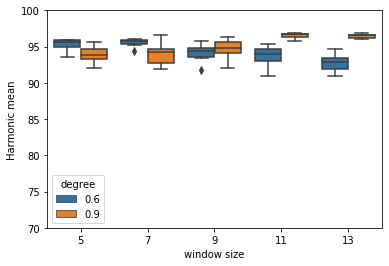

In [7]:
df_res=pd.DataFrame(res)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='Harmonic mean')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='Harmonic mean', hue="degree",data=b)
plt.ylim(70,100)
df_res_mean=pd.DataFrame(res_mean,index=['harmonic mean'])
print(df_res_mean)
plt.title('harmonic mean')
plt.savefig('wsii_fishing.png')

            0.6                                                    0.9  \
             5          7          9          11         13         5    
purity  95.3164  95.574635  94.150787  93.607521  92.820218  93.916848   

                                                  
               7        9          11         13  
purity  94.046834  94.6536  96.511667  96.470498  


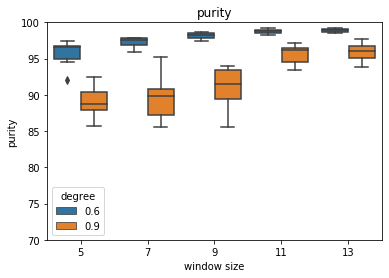

In [8]:
df_res=pd.DataFrame(pres)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='purity')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='purity', hue="degree",data=b)
plt.ylim(70,100)
df_res_mean=pd.DataFrame(res_mean,index=['purity'])
print(df_res_mean)
plt.title('purity')
plt.savefig('purity_wsii_fishing.png')

              0.6                                                    0.9  \
               5          7          9          11         13         5    
coverage  95.3164  95.574635  94.150787  93.607521  92.820218  93.916848   

                                                    
                 7        9          11         13  
coverage  94.046834  94.6536  96.511667  96.470498  


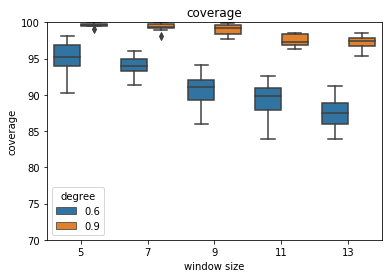

In [9]:
df_res=pd.DataFrame(cres)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='coverage')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='coverage', hue="degree",data=b)
plt.ylim(70,100)
df_res_mean=pd.DataFrame(res_mean,index=['coverage'])
print(df_res_mean)
plt.title('coverage')
plt.savefig('coverage_wsii_fishing.png')

In [10]:
s=0
u=[]
ts=0
for l in listoffiles:
    df=read_fold(file_name=l,new_columns_names={'latitude': 'lat','longitude': 'lon'})
    #print(l,df.shape[0])
    ks=0
    for k,v in df.groupby(['tsid']):
        #print(k,v.shape[0])
        ks=ks+1
    s=s+df.shape[0]
    u.append([ks])
    ts=ts+ks
print("number of trajectory points:",s,"segments in each fold:",u,"Number of segments:",ts)

number of trajectory points: 5190 segments in each fold: [[10], [19], [18], [22], [20], [10], [16], [14], [16], [8]] Number of segments: 153
